In [1]:
from ki_ueben.datasets import Maestro3Dataset
from ki_ueben.midi import PianoRoll

In [2]:
midi_files = Maestro3Dataset().midi_file_paths

In [3]:
piano_roll = PianoRoll(midi_file_path=midi_files)

In [8]:
x.shape

(146124, 335)

In [4]:
performance_vectors = piano_roll.performance_vector()

/home/dennis/git/ki-ueben-klavier-trainieren/book/chapters/ki_ueben/midi.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for time_slot, time_group in events_df.groupby("time_slot"):


In [12]:
events_df = piano_roll.events()

In [13]:
import numpy as np
import pandas as pd

time_slots = np.arange(0.0, np.ceil(events_df['time'].max()), 0.008)
events_df['time_slot'] = pd.cut(
    events_df['time'],
    bins=time_slots,
    include_lowest=True,
    labels=np.arange(0, len(time_slots)-1),
) # type: ignore


In [17]:
for time_slot, time_group in events_df.groupby("time_slot", observed=False):
    break

In [10]:
performance_vectors[4]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [10]:
x[20:30].shape

(10, 335)

In [7]:
x = piano_roll.performance_vector()

/home/dennis/git/ki-ueben-klavier-trainieren/book/chapters/ki_ueben/midi.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for time_slot, time_group in events_df.groupby("time_slot"):


In [1]:
from ki_ueben.datasets import Maestro3Dataset, PerformanceDataset
from torch.utils.data import DataLoader

WINDOW_SIZE = 50
VEC_SIZE = 89 + 89 + 125 + 32

performance_dataset = PerformanceDataset(
    # limit the number of MIDI files
    midi_files=Maestro3Dataset().midi_file_paths,
    window_size=WINDOW_SIZE,
)

In [2]:
performance_data_loader = DataLoader(performance_dataset, batch_size=256, num_workers=16)

In [3]:
import lightning as L
from torch import nn, optim


class PerformanceNet(L.LightningModule):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int = 1,
        dropout: float = 0.2,
        learning_rate: float = 1e-4,
    ):
        super().__init__()
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        rnn_out, _ = self.lstm(x)
        # only use output from last step of our rnn sequence
        output = self.fc(rnn_out[:, -1, :])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.squeeze(1))
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)


performance_net = PerformanceNet(
    input_size=VEC_SIZE,
    output_size=VEC_SIZE,
    hidden_size=512,
    num_layers=3,
    learning_rate=0.001,
)

print(performance_net)

PerformanceNet(
  (lstm): LSTM(335, 512, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=512, out_features=335, bias=True)
  (criterion): BCEWithLogitsLoss()
)


In [4]:
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
import torch 

# for tensor cores
torch.set_float32_matmul_precision('high')

simple_trainer = L.Trainer(
    max_epochs=5,
    logger=[
        CSVLogger(save_dir="logs", name="performance_net", version=0),
        TensorBoardLogger(save_dir="logs", name="performance_net_tb", version=0, log_graph=True,)
    ]
)
simple_trainer.fit(model=performance_net, train_dataloaders=performance_data_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/performance_net/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory logs/performance_net/version_0/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | lstm      | LSTM              | 5.9 M  | train
1 | fc        | Linear            | 171 K  | train
2 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
6.1 M     Trainab

Epoch 0: |          | 2314/? [02:04<00:00, 18.55it/s, v_num=0, train_loss=0.0385]

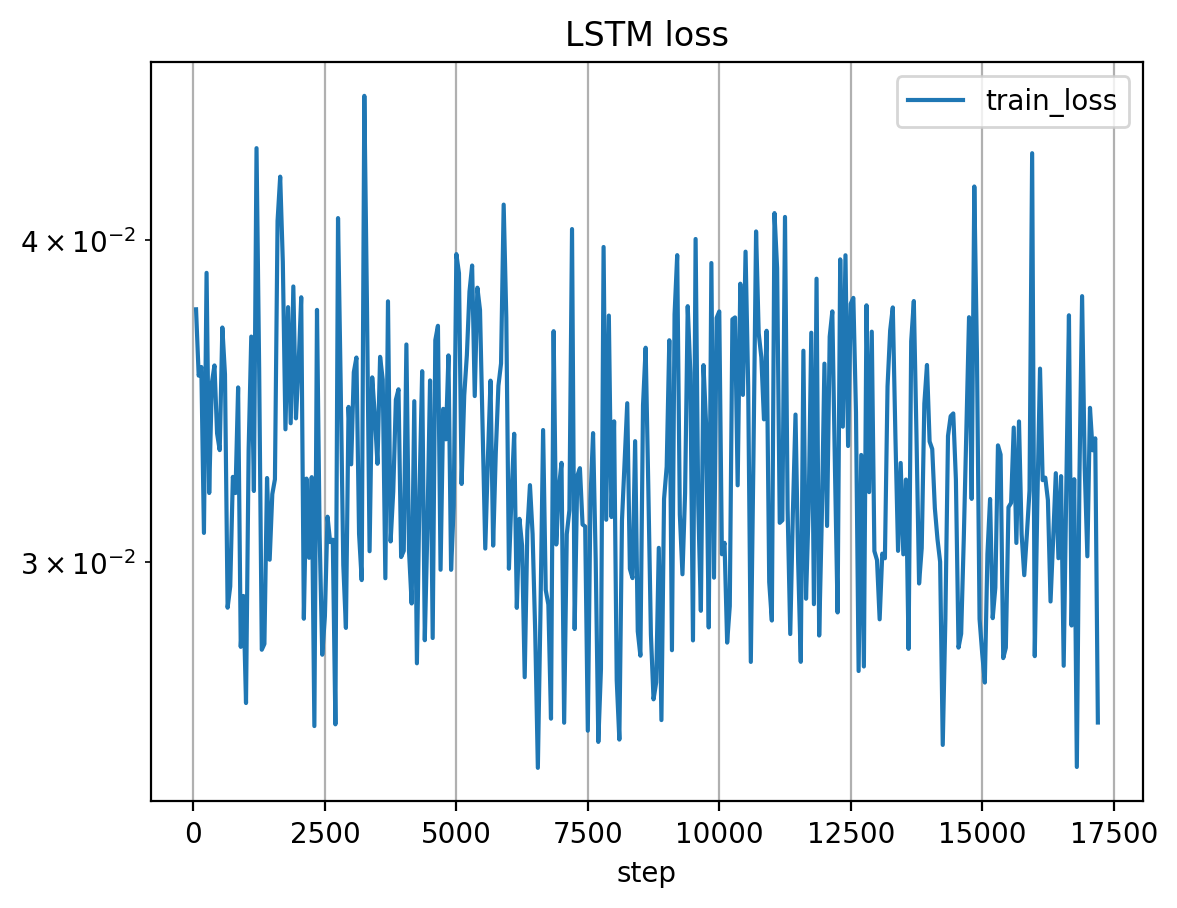

In [7]:
import pandas as pd

df_simple_metrics = pd.read_csv("logs/performance_net/version_0/metrics.csv")
df_simple_metrics.plot.line(
    grid=True, title="LSTM loss", x="step", y="train_loss", logy=True
);

In [8]:
for i, sample in enumerate(performance_dataset):
    performance_sample = sample
    if i == 10:
        break
performance_sample

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


In [10]:
performance_sample[0].shape

torch.Size([50, 335])

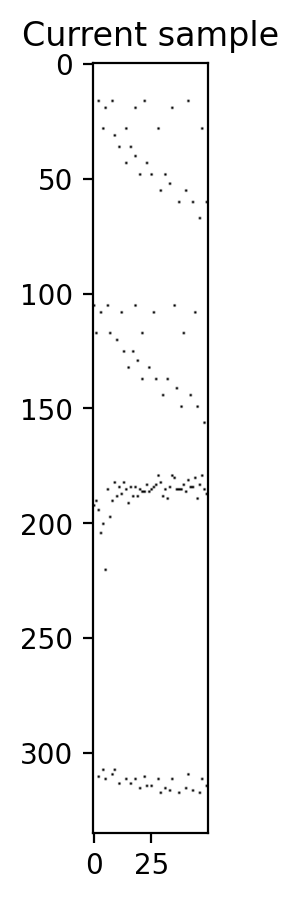

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(performance_sample[0].T, cmap="binary");
plt.title("Current sample");

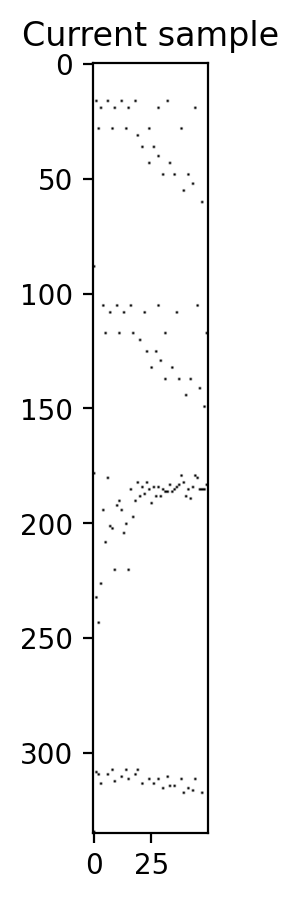

In [12]:
for sample in performance_dataset:
    performance_sample = sample
    break

import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.imshow(performance_sample[0].T, cmap="binary");
plt.title("Current sample");
note_sequence = performance_sample[0]


/home/dennis/git/ki-ueben-klavier-trainieren/venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


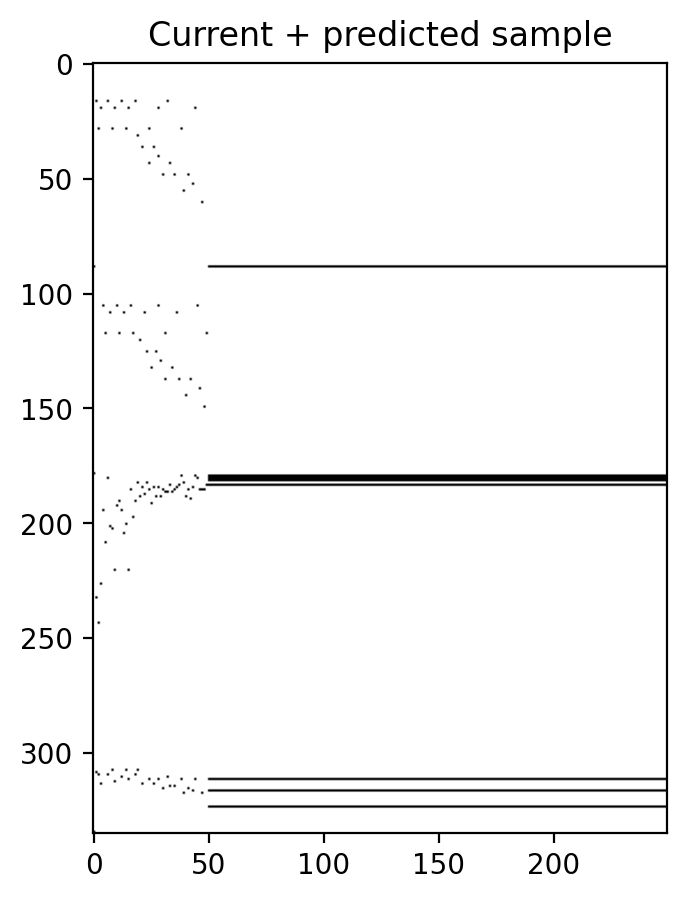

In [13]:

for i in range(200):
    next_frame = performance_net.forward(note_sequence.unsqueeze(0))
    binary_frame = (torch.nn.Softmax()(next_frame) > 0.01).to(torch.float32)
    note_sequence = torch.concat([note_sequence, binary_frame])
    # print(note_sequence.shape)

predicted_sequence = note_sequence.detach().numpy()

plt.figure(figsize=(10, 5))
plt.imshow(predicted_sequence.T, cmap="binary");
plt.title("Current + predicted sample");